In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# import pandas as pd
import numpy as np
import seaborn as sns
# import matplotlib.pyplot as plt  



Current y-limits: (np.float64(-50000000000.0), np.float64(50000000000.0))


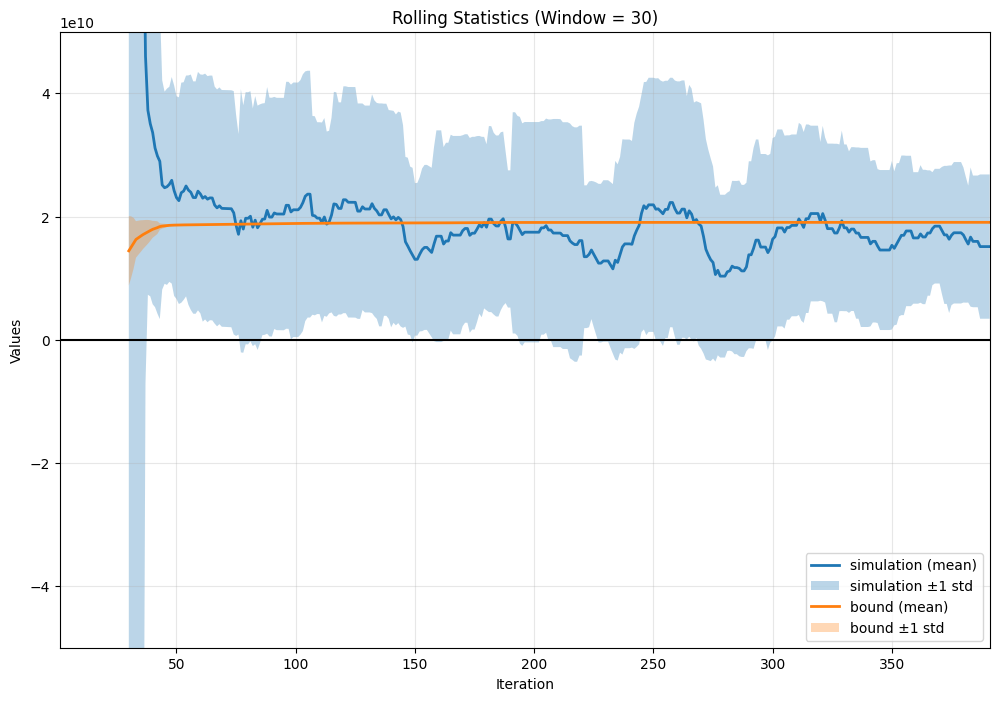

In [2]:
output_dir = "../../output/stochastic_solution"
training = pd.read_csv(output_dir+"/training_results.csv").set_index("iteration")

# Drop the 'time' column (note the space before 'time')
training = training.drop(' time', axis=1)

# Calculate rolling statistics
window = 30
rolling_mean = training.rolling(window).mean()
rolling_std = training.rolling(window).std()

# Create the plot
plt.figure(figsize=(12, 8))
ax = plt.subplot()

# Plot each remaining column with mean and shaded standard deviation
for column in training.columns:
    # Plot rolling mean as solid line
    plt.plot(rolling_mean.index, rolling_mean[column], label=f'{column.strip()} (mean)', linewidth=2)
    
    # Plot shaded area for standard deviation
    plt.fill_between(rolling_mean.index,
                    rolling_mean[column] - rolling_std[column],
                    rolling_mean[column] + rolling_std[column],
                    alpha=0.3, label=f'{column.strip()} ±1 std')

plt.xlabel('Iteration')
plt.ylabel('Values')
plt.title(f'Rolling Statistics (Window = {window})')
plt.legend()
plt.grid(True, alpha=0.3)

# Uncomment if you want logarithmic scale
# plt.yscale("log")
# plt.xscale("log")
ax.set_ylim(-0.5e11, 0.5e11)  # or some other reasonable lower bound
ax.set_xlim(min(rolling_mean.index), max(rolling_mean.index))  # or some other reasonable lower bound
plt.hlines(y = 0, xmin = 0, xmax = ax.get_xlim()[1], colors = ["k"])
print(f"Current y-limits: {ax.get_ylim()}")
# Then set appropriate limits based on the actual range
# plt.tight_layout()
plt.show()

In [3]:
# output_dir = "../../output"
# training = pd.read_csv(output_dir+"/training_results.csv").set_index("iteration")

# # Drop the 'time' column (note the space before 'time')
# training = training.drop(columns = {' bound', " simulation"}, axis=1)

# # Calculate rolling statistics
# # window = 100
# # rolling_mean = training.rolling(window).mean()
# # rolling_std = training.rolling(window).std()

# # Create the plot
# plt.figure(figsize=(12, 8))

# # Plot each remaining column with mean and shaded standard deviation
# for column in training.columns:
#     # Plot rolling mean as solid line
#     plt.plot(training.index, training[column], label=f'{column.strip()} (mean)', linewidth=2)
    
#     # Plot shaded area for standard deviation
#     plt.fill_between(training.index)
#                     # training[column] - training[column],
#                     # training[column] + training[column],
#                     # alpha=0.3, label=f'{column.strip()} ±1 std')

# plt.xlabel('Iteration')
# plt.ylabel('Values')
# plt.title(f'Rolling Statistics (Window = {window})')
# plt.legend()
# plt.grid(True, alpha=0.3)

# # Uncomment if you want logarithmic scale
# # plt.ylim(-1e11,1e11)

# plt.tight_layout()
# plt.show()

In [4]:

output_dir = "../../output"
operations =  pd.read_csv(output_dir+"/operational_sim1.csv")
TECH_COLORS = {
    "CHP": "#E41A1C",        # red
    "HeatPump": "#377EB8",   # blue
    "Geothermal": "#4DAF4A", # green
    "Boiler": "#984EA3",     # purple
    "Pit": "#DC74FF",        # orange
    "BioOil_Boiler": "#6C3C0C",        # orange
}

print(operations)

       year        type           technology  period  hour        value
0      2025  Production  WasteWater_HeatPump       0     0   191.847445
1      2025  Production  WasteWater_HeatPump       0     1   161.254455
2      2025  Production  WasteWater_HeatPump       0     2   215.601323
3      2025  Production  WasteWater_HeatPump       0     3   220.000000
4      2025  Production  WasteWater_HeatPump       0     4   220.000000
...     ...         ...                  ...     ...   ...          ...
16123  2050      Demand                    /       7    19  1341.301861
16124  2050      Demand                    /       7    20  1282.396899
16125  2050      Demand                    /       7    21  1209.868075
16126  2050      Demand                    /       7    22  1192.750668
16127  2050      Demand                    /       7    23  1164.300934

[16128 rows x 6 columns]


In [5]:
int(operations[["hour"]].nunique())

/var/folders/_8/5wkhjk491lg_89k0811g6vlm0000gn/T/ipykernel_27423/2621661908.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(operations[["hour"]].nunique())


24

In [6]:

def plot_energy(df, tech_order=None, tech_colors=TECH_COLORS):
    df = df.sort_values(["year", "period", "hour"]).copy()
    nhours= int(operations[["hour"]].nunique())
    nperiod= int(operations[["period"]].nunique())
    nslice=4
    df["x"] = df["period"] * nhours + df["hour"]

    sns.set_style("whitegrid")

    # Dictionary to store dynamically assigned colors
    dynamic_colors = {}

    def get_color(tech):
        # Use predefined first
        if tech_colors and tech in tech_colors:
            return tech_colors[tech]

        # Else reuse or assign new unique color
        if tech not in dynamic_colors:
            palette = sns.color_palette("Paired", 10)
            dynamic_colors[tech] = palette[len(dynamic_colors) % len(palette)]
        return dynamic_colors[tech]

    def apply_order(pivot_df):
        """
        Returns technologies sorted by (sum / max) in descending order
        """
        sums = pivot_df.sum()
        maxs = pivot_df.max()
        
        # Calculate quotient (sum / max), handling division by zero
        quotient = sums / maxs.replace(0, 1)  # Replace 0 max with 1 to avoid division by zero
        
        # Sort by quotient in descending order
        sorted_techs = quotient.sort_values(ascending=False).index.tolist()
        
        return sorted_techs

    for year, df_y in df.groupby("year"):
        fig, ax = plt.subplots(figsize=(10, 5))
        plt.title(f"Energy Balance – {year}", fontsize=16)

        bottom = np.zeros(len(df_y["x"].unique()))

        def stacked_fill(df_type, alpha, prefix=""):
            nonlocal bottom
            if df_type.empty:
                return

            pivot = (
                df_type.pivot_table(index="x", columns="technology",
                                    values="value", aggfunc="sum")
                .fillna(0)
            )
            # Drop columns where sum of values is 0
            pivot = pivot.loc[:, pivot.sum() != 0]

            techs = apply_order(pivot)
            # bottom = np.zeros(len(pivot))

            for tech in techs:
                vals = pivot[tech].values
                ax.fill_between(
                    pivot.index,
                    bottom,
                    bottom + vals,
                    alpha=alpha,
                    color=get_color(tech),
                    linewidth=0,   # NO borders ✅
                    label=f"{prefix}{tech}" if prefix else tech,
                )
                bottom += vals

        # Plot production first → base
        stacked_fill(df_y[df_y["type"] == "Production"], alpha=0.9)

        # Discharge and Unmet on top
        stacked_fill(df_y[df_y["type"] == "Discharge"], alpha=0.5, prefix="Discharge - ")
        stacked_fill(df_y[df_y["type"] == "Unmet"], alpha=0.5, prefix="Unmet - ")

        # Demand → black line
        df_demand = df_y[df_y["type"] == "Demand"]
        if not df_demand.empty:
            demand = df_demand.groupby("x")["value"].sum()
            ax.plot(demand.index, demand.values, color="black",
                    lw=1, label="Demand")

        # period separators
        for w in sorted(df_y["period"].unique()):
            ax.axvline(w * nhours, linestyle="--", color="k", linewidth=1)

        # x-axis formatting
        ax.set_xlim(df_y["x"].min(), df_y["x"].max())
        ax.set_ylim(df_y["x"].min(), 1.1*df_y["value"].max())
        periods = sorted(df_y["period"].unique())
        ticks = [w * nhours + d * int(nhours/nslice) for w in periods for d in range(nslice)]
        ax.set_xticks(ticks)
        ax.set_xticklabels([f"{(t % nhours)}h" for t in ticks], rotation=45)

        plt.xlabel("Hours")
        plt.ylabel("Energy Value")
        plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8, ncol=1)
        plt.tight_layout()
        plt.savefig(output_dir+f"/postprocessed/periodEnergyBalance{year}.pdf")
        plt.show()


/var/folders/_8/5wkhjk491lg_89k0811g6vlm0000gn/T/ipykernel_27423/1404491365.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  nhours= int(operations[["hour"]].nunique())
/var/folders/_8/5wkhjk491lg_89k0811g6vlm0000gn/T/ipykernel_27423/1404491365.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  nperiod= int(operations[["period"]].nunique())


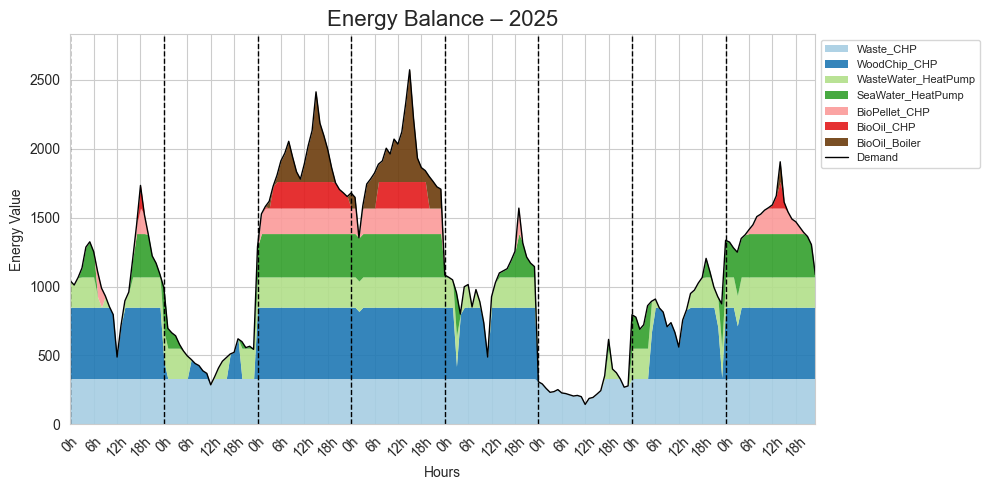

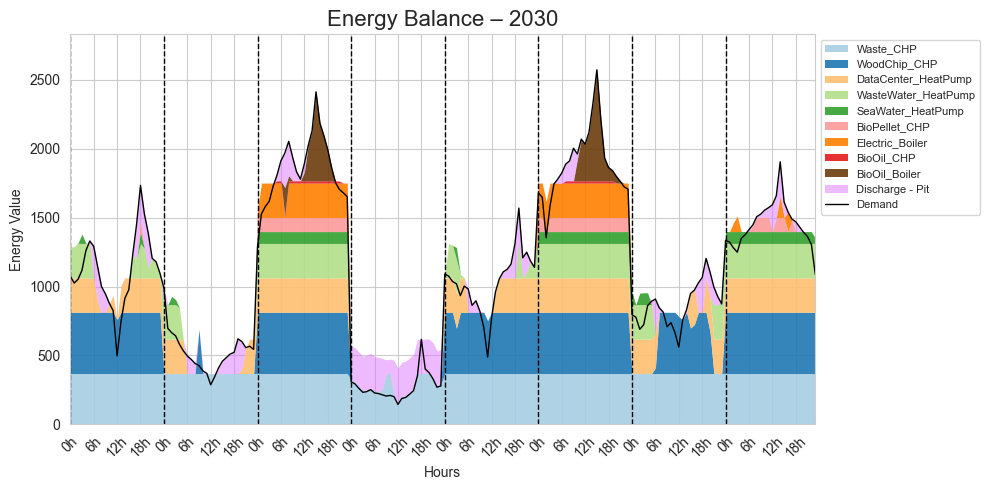

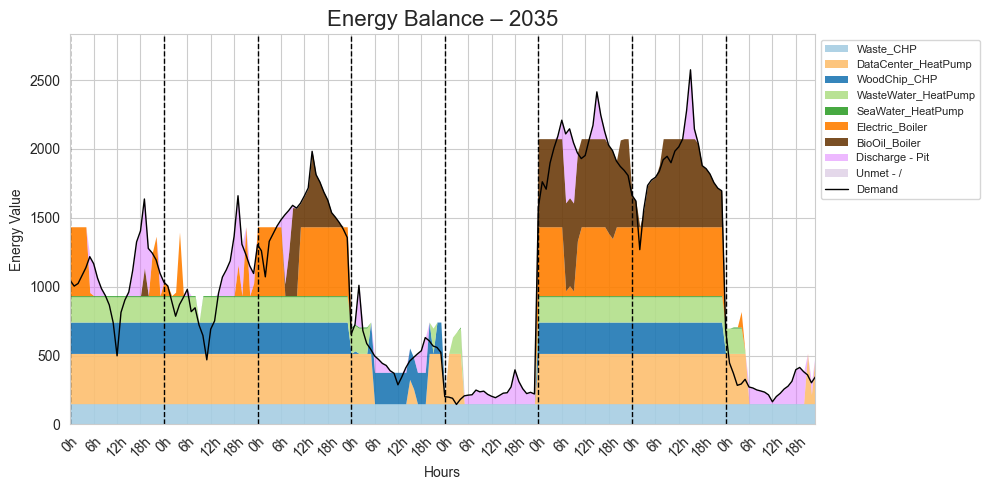

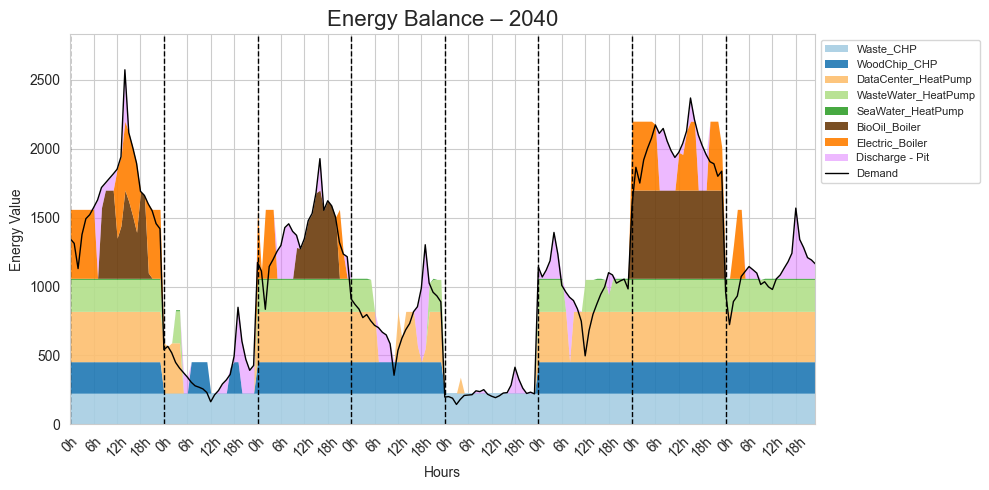

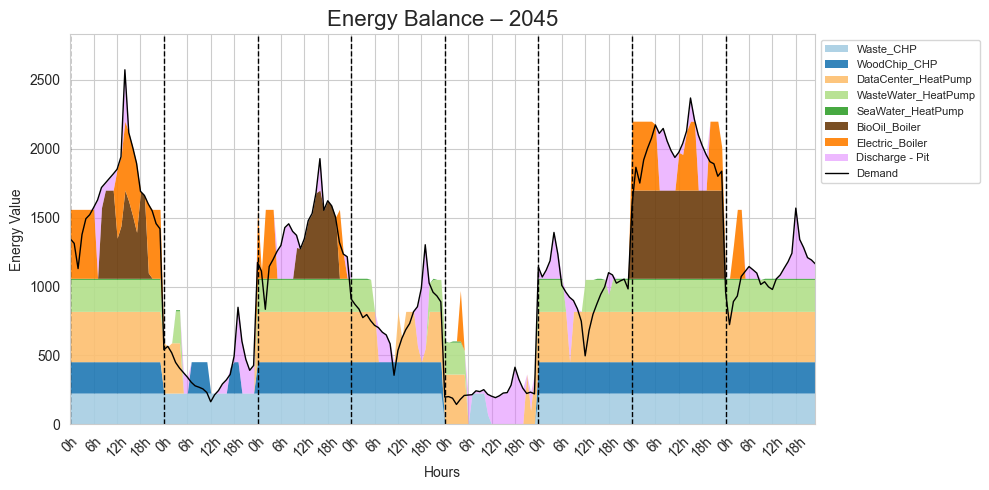

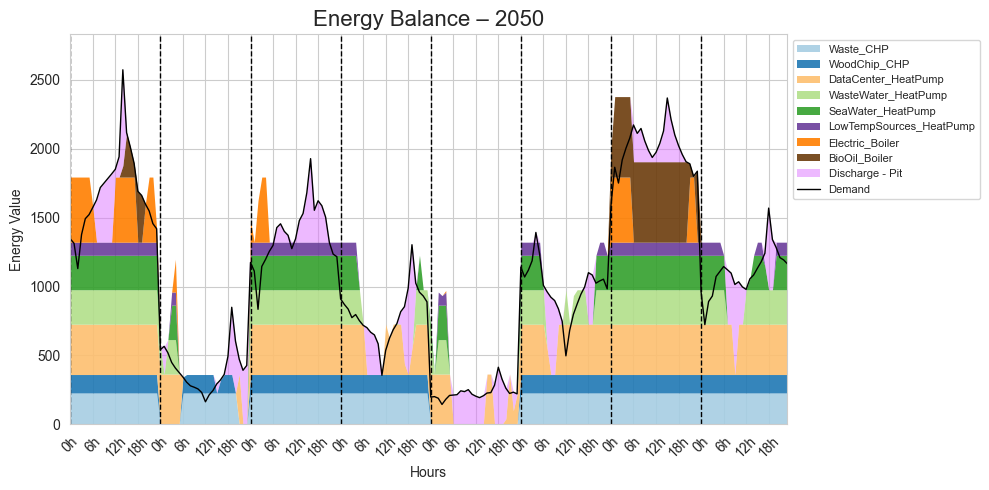

In [7]:
# df = pd.read_csv("operational_results.csv")
plot_energy(operations, tech_order = ["CHP","Geothermal","HeatPump","Boiler"])


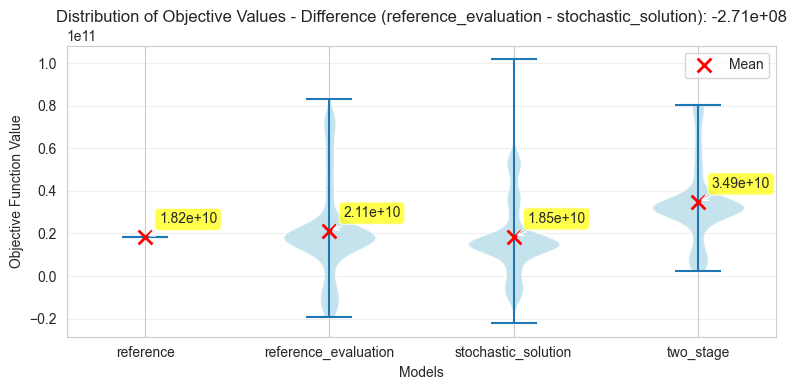

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # Collect data from all models
# data = []
# labels = []

#     values = df.groupby(by="simulation").sum()["objective"]
#     data.append(values)
#     labels.append(model)

# # Create violin plot
# plt.figure(figsize=(10, 6))
# violin_parts = plt.violinplot(data, showmeans=False, showmedians=False)

# # Customize violin plot colors
# for pc in violin_parts['bodies']:
#     pc.set_facecolor('lightblue')
#     pc.set_alpha(0.7)

# # Calculate and plot means as crosses
# means = [np.mean(d) for d in data]
# x_positions = range(1, len(means) + 1)

# plt.scatter(x_positions, means, marker='x', color='red', s=100, linewidth=2, zorder=3, label='Mean')

# # Customize the plot
# plt.xticks(range(1, len(labels) + 1), labels)
# plt.xlabel('Models')
# plt.ylabel('Objective Function Value')
# plt.title('Distribution of Objective Values Across Simulations')
# plt.grid(axis='y', alpha=0.3)
# plt.legend()

# plt.tight_layout()
# plt.show()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Collect data from all models
data = []
labels = []
means_dict = {}

for model in ["reference", "reference_evaluation", "stochastic_solution", "two_stage"]:
    df = pd.read_csv(f"../../output/{model}/objective_overview.csv")
    values = df.groupby(by="simulation").sum()["objective"]
    data.append(values)
    labels.append(model)
    means_dict[model] = np.mean(values)

# Calculate the difference for the title
difference =  means_dict["reference_evaluation"] - means_dict["stochastic_solution"]
difference_formatted = f"{difference:.2e}"

# Create violin plot
plt.figure(figsize=(8, 4))
violin_parts = plt.violinplot(data, showmeans=False, showmedians=False)

# Customize violin plot colors
for pc in violin_parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(0.7)

# Calculate and plot means as crosses
means = [means_dict[label] for label in labels]
x_positions = range(1, len(means) + 1)

plt.scatter(x_positions, means, marker='x', color='red', s=100, linewidth=2, zorder=3, label='Mean')

# Annotate mean values next to crosses
for i, (x, mean_val) in enumerate(zip(x_positions, means)):
    plt.annotate(f'{mean_val:.2e}', 
                xy=(x, mean_val), 
                xytext=(10, 10),
                textcoords='offset points',
                fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Customize the plot
plt.xticks(range(1, len(labels) + 1), labels)
plt.xlabel('Models')
plt.ylabel('Objective Function Value')
plt.title(f'Distribution of Objective Values - Difference (reference_evaluation - stochastic_solution): {difference_formatted}')
plt.grid(axis='y', alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()